In [116]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px

In [117]:
root = '../data/'

friends = pd.read_csv(root + 'dataset.csv')
friends.head()

,user_id,car_id,interaction
0,0,0,1.0
1,1,0,0.0
2,2,0,0.0
3,3,0,0.0
4,4,0,0.0


In [118]:
friends = friends.rename(columns={
    "user_id":"u",
    "car_id": "t",
    "interaction": "h"
})

In [119]:
friends.head()

,u,t,h
0,0,0,1.0
1,1,0,0.0
2,2,0,0.0
3,3,0,0.0
4,4,0,0.0


In [120]:
print(f'Unique friends u: {len(friends.u.unique())}')

Unique friends u: 75


In [121]:
friends.sort_values(by=['u'])

,u,t,h
0,0,0,1.0
1125,0,18,0.0
1725,0,35,0.0
4200,0,201,0.0
3975,0,170,0.0
...,...,...,...
3674,74,143,0.0
4949,74,246,0.0
3224,74,115,0.0
3974,74,153,0.0


In [122]:
nodes = pd.concat([friends.u, friends.t]).sort_values().unique()
num_nodes = len(nodes)

In [123]:
num_nodes

152

<AxesSubplot: xlabel='h', ylabel='Count'>

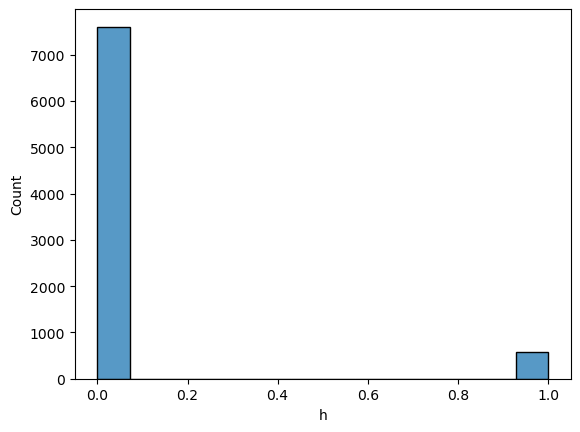

In [124]:
sns.histplot(friends.h)

In [125]:
from scipy.sparse import csr_matrix
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from multiprocessing import Pool, cpu_count


class EASE:
    def __init__(self):
        self.user_enc = LabelEncoder()
        self.item_enc = LabelEncoder()

    def _get_users_and_items(self, df):
        users = self.user_enc.fit_transform(df.loc[:, 'user_id'])
        items = self.item_enc.fit_transform(df.loc[:, 'item_id'])
        return users, items

    def fit(self, df, lambda_: float = 0.5, implicit=True):
        """
        df: pandas.DataFrame with columns user_id, item_id and (rating)
        lambda_: l2-regularization term
        implicit: if True, ratings are ignored and taken as 1, else normalized ratings are used
        """
        users, items = self._get_users_and_items(df)
        values = (
            np.ones(df.shape[0])
            if implicit
            else df['rating'].to_numpy() / df['rating'].max()
        )

        X = csr_matrix((values, (users, items)))
        self.X = X

        G = X.T.dot(X).toarray()
        diagIndices = np.diag_indices(G.shape[0])
        G[diagIndices] += lambda_
        P = np.linalg.inv(G)
        B = P / (-np.diag(P))
        B[diagIndices] = 0

        self.B = B
        self.pred = X.dot(B)

    def predict(self, train, users, items, k):
        items = self.item_enc.transform(items)
        dd = train.loc[train.user_id.isin(users)]
        dd['ci'] = self.item_enc.transform(dd.item_id)
        dd['cu'] = self.user_enc.transform(dd.user_id)
        g = dd.groupby('cu')
        with Pool(cpu_count()) as p:
            user_preds = p.starmap(
                self.predict_for_user,
                [(user, group, self.pred[user, :], items, k) for user, group in g],
            )
        df = pd.concat(user_preds).astype(int)
        df['item_id'] = self.item_enc.inverse_transform(df['item_id'])
        df['user_id'] = self.user_enc.inverse_transform(df['user_id'])
        return df

    @staticmethod
    def predict_for_user(user, group, pred, items, k):
        watched = set(group['ci'])
        candidates = [item for item in items if item not in watched]
        pred = np.take(pred, candidates)
        res = np.argpartition(pred, -k)[-k:]
        r = pd.DataFrame(
            {
                "user_id": [user] * len(res),
                "item_id": np.take(candidates, res),
                "score": np.take(pred, res),
            }
        ).sort_values('score', ascending=False)
        return r

In [126]:
ease = EASE()

In [127]:
friends = friends.rename(columns={'u':'user_id', 't':'item_id', 'h':'rating'})
friends_t = friends.copy()
friends_t['user_id'] = friends['item_id']
friends_t['item_id'] = friends['user_id']
# all_interactions = pd.concat([friends, friends_t])
all_interactions = friends.copy()

In [128]:
all_interactions.rating.mean()

0.06996941896024465

In [129]:
ease.fit(all_interactions, implicit=False, lambda_=8.0)

In [130]:
all_interactions

,user_id,item_id,rating
0,0,0,1.0
1,1,0,0.0
2,2,0,0.0
3,3,0,0.0
4,4,0,0.0
...,...,...,...
8170,70,402,0.0
8171,71,402,0.0
8172,72,402,0.0
8173,73,402,0.0


In [131]:
preds = ease.predict(all_interactions, nodes, nodes, k=11)

ValueError: y contains previously unseen labels: [1, 14, 16, 24, 25, 26, 27, 29, 30, 31, 32, 34, 36, 37, 38, 39, 41, 42, 43, 44, 46, 47, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58, 60, 61, 63, 65, 66, 67, 68, 70, 71, 72, 73]

In [ ]:
preds

,user_id,item_id,score
8,1,14,0
9,1,48,0
10,1,52,0
6,1,24,0
5,1,25,0
...,...,...,...
10,402,365,0
3,402,309,0
2,402,317,0
1,402,85,0


In [ ]:
ans = []
preds = preds[preds['user_id']!=preds['item_id']]

for user in preds.user_id.unique():
    ans.append(f'{user}: {list(preds[preds["user_id"]==user].item_id)[:10]}'.replace('[', '').replace(']', ''))

In [ ]:
px.imshow(pd.pivot_table(data=preds, index="user_id", columns="item_id", values="score"))

In [ ]:
pred_interactions = dict([[int(item[0]), [int(x) for x in item[1].split(",")]] for item in [item.split(":") for item in ans]])

In [ ]:
pd.pivot_table(data=friends, index="user_id", columns="item_id", values="rating").iloc[:0]

item_id,0,2,3,4,5,6,7,8,9,10,...,370,373,376,380,382,387,389,395,397,402
user_id,,,,,,,,,,,,,,,,,,,,,


In [ ]:
import pandas as pd

data = dict([[int(item[0]), [int(x) for x in item[1].split(",")]] for item in [item.split(":") for item in ans]])

# Create a list of tuples containing user_id and item_id
data_tuples = []
for user_id, items in data.items():
    for item_id in items:
        data_tuples.append((user_id, item_id))

# Create a pandas DataFrame from the list of tuples
df = pd.DataFrame(data_tuples, columns=['user_id', 'item_id'])

# Create a pivot table from the DataFrame
pivot_table = df.pivot_table(index='user_id', columns='item_id', aggfunc=len, fill_value=0)

px.imshow(pivot_table)

In [ ]:
px.imshow(pd.pivot_table(data=friends, index="user_id", columns="item_id", values="rating"))

In [ ]:
pivot_table

item_id,1,14,16,24,25,26,27,29,30,31,...,358,364,365,373,380,382,387,395,397,402
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,1,0,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
14,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
25,1,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
389,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
395,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0


In [ ]:
ans

['1: 14, 48, 52, 24, 25, 42, 26, 49, 66, 31',
 '14: 63, 1, 41, 24, 49, 48, 34, 54, 42, 47',
 '16: 24, 48, 49, 47, 66, 26, 72, 61, 63, 71',
 '24: 71, 51, 34, 53, 16, 47, 52, 32, 66, 31',
 '25: 47, 58, 66, 68, 1, 71, 27, 70, 30, 56',
 '26: 60, 71, 63, 73, 31, 32, 27, 16, 1, 38',
 '27: 52, 49, 38, 58, 47, 26, 48, 30, 54, 70',
 '29: 34, 47, 65, 48, 63, 24, 32, 46, 51, 37',
 '30: 65, 58, 24, 38, 27, 66, 52, 68, 61, 34',
 '31: 49, 48, 24, 26, 36, 41, 72, 1, 47, 65',
 '32: 48, 63, 24, 49, 26, 34, 57, 43, 61, 42',
 '34: 58, 41, 24, 63, 61, 37, 29, 47, 46, 57',
 '36: 63, 41, 65, 43, 31, 51, 42, 52, 38, 39',
 '37: 34, 48, 49, 24, 41, 58, 39, 63, 52, 73',
 '38: 27, 73, 52, 48, 56, 61, 30, 41, 36, 43',
 '39: 67, 63, 34, 47, 36, 51, 37, 44, 26, 38',
 '41: 67, 34, 54, 14, 36, 42, 31, 38, 37, 46',
 '42: 51, 41, 36, 1, 58, 32, 72, 43, 37, 70',
 '43: 48, 36, 61, 32, 63, 38, 51, 67, 24, 37',
 '44: 34, 71, 32, 1, 51, 39, 67, 60, 54, 46',
 '46: 34, 63, 41, 44, 32, 29, 65, 39, 1, 47',
 '47: 25, 24, 34, 73,

In [ ]:
preds

,user_id,item_id,score
8,1,14,0
9,1,48,0
10,1,52,0
6,1,24,0
5,1,25,0
...,...,...,...
10,402,365,0
3,402,309,0
2,402,317,0
1,402,85,0


In [ ]:
with open(root + "submission_ease.txt", "w") as fout:
    print("\n".join(ans), file=fout)